In [102]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [73]:
# Load the data
file_path = "C:\\Users\\Rajan\\Desktop\\IRFC\\IRFC_data.csv"
data = pd.read_csv(file_path)
data = data.iloc[:, :-1]
data.isnull().sum()

Date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64

In [114]:
data

,open,high,low,close,adjclose,volume
Date,,,,,,
2021-01-29,24.900000,25.799999,24.350000,24.799999,21.363667,381938573
2021-02-01,25.250000,25.400000,24.900000,25.100000,21.622095,72044464
2021-02-02,25.450001,25.450001,24.700001,24.750000,21.320593,36735442
2021-02-03,24.799999,24.900000,24.049999,24.250000,20.889874,45816269
2021-02-04,24.250000,25.799999,23.850000,25.350000,21.837458,88486029
...,...,...,...,...,...,...
2024-04-23,144.750000,148.199997,143.600006,147.750000,147.750000,41842082
2024-04-24,149.000000,150.449997,147.500000,149.000000,149.000000,44593104
2024-04-25,149.000000,152.000000,147.250000,150.250000,150.250000,43990323


In [74]:
# Convert 'date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [75]:
# Sorting as per date
data.sort_index(inplace=True)


In [76]:
# Normalization
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'adjclose']])
scaled_data = pd.DataFrame(scaled_features, columns=['open', 'high', 'low', 'close', 'adjclose'], index=data.index)


In [77]:
# Creating lag features for 'close' price in scaled_data
scaled_data['close_lag1'] = scaled_data['close'].shift(1)
scaled_data['close_lag2'] = scaled_data['close'].shift(2)


In [78]:
# Drop rows with NaN values created by the lag features
scaled_data.dropna(inplace=True)

In [79]:
# Define the train-test split ratio
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [80]:
# Define the target variable and features
X_train = train_data[['open', 'high', 'low', 'close_lag1', 'close_lag2']].values
y_train = train_data['close'].values


In [81]:
X_test = test_data[['open', 'high', 'low', 'close_lag1', 'close_lag2']].values
y_test = test_data['close'].values


In [82]:
# Reshape the data into the format [samples, timesteps, features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)


In [83]:
# Reshape data to 3D [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [104]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(70, return_sequences=False))
model.add(Dense(1))
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

C:\Users\Rajan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [106]:
history = model.fit(X_train, y_train, epochs=45, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.1439e-04 - val_loss: 0.0029
Epoch 2/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7463e-05 - val_loss: 0.0019
Epoch 3/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8750e-05 - val_loss: 0.0013
Epoch 4/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8912e-05 - val_loss: 4.8875e-04
Epoch 5/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9109e-05 - val_loss: 1.0094e-04
Epoch 6/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0609e-06 - val_loss: 6.1423e-05
Epoch 7/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1401e-06 - val_loss: 5.9267e-05
Epoch 8/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2870e-06 - val_loss: 5.9377e-05
Epoch 9/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8515e-06 - val_loss: 5.9483e-05
Epoch 10/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2231e-06 - val_loss: 5.9974e-05
Epoch 11/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0493e-06 - val_loss: 5.9325e-

In [107]:
# Make predictions
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [108]:
# Inverse transform predictions to get actual values (if needed)
def inverse_transform_single_column(scaler, data, column_index):
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, column_index] = data[:, 0]
    return scaler.inverse_transform(dummy)[:, column_index]

In [109]:
# Inverse transform y_test and y_pred
y_test_inv = inverse_transform_single_column(scaler, y_test.reshape(-1, 1), data.columns.get_loc('close'))
y_pred_inv = inverse_transform_single_column(scaler, y_pred, data.columns.get_loc('close'))


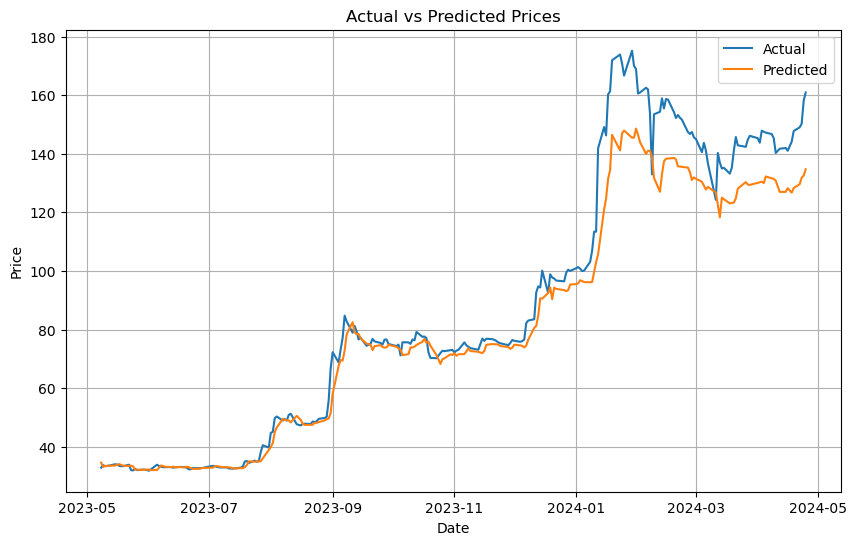

In [110]:
# Adjusting the indices to match the lengths of y_test_inv and y_pred_inv
adjusted_index = data.index[train_size + time_steps:train_size + time_steps + len(y_test_inv)]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(adjusted_index, y_test_inv, label='Actual')
plt.plot(adjusted_index, y_pred_inv, label='Predicted')
plt.legend()
plt.grid(True)  # Add grid
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Price')  # Label for y-axis
plt.title('Actual vs Predicted Prices')  # Title for the plot
plt.show()

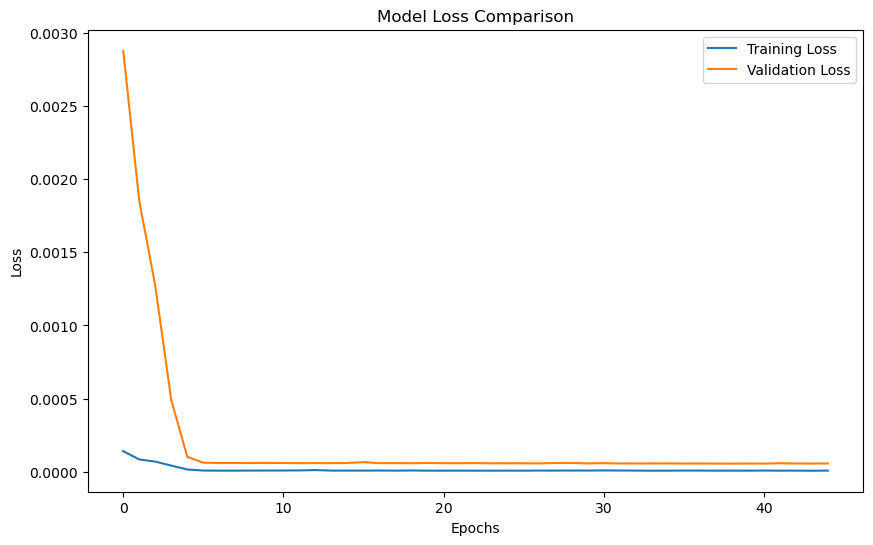

In [111]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [112]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
# Calculate accuracy metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 6.690590251250037
Root Mean Squared Error: 10.50255854723997
R-squared: 0.9464796552484989
